## Import

In [32]:
import numpy as np
import pandas as pd
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import talib
from pingouin import welch_anova
from scikit_posthocs import posthoc_scheffe

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

## Read data

In [33]:
msft, msft_fs = pd.read_pickle('data/msft.pkl')
ma, ma_fs = pd.read_pickle('data/ma.pkl')
intc, intc_fs = pd.read_pickle('data/intc.pkl')
mcd, mcd_fs = pd.read_pickle('data/mcd.pkl')
aapl, aapl_fs = pd.read_pickle('data/aapl.pkl')

In [34]:
economics = pd.read_pickle('data/economics.pkl')

## Data Cleansing

#### 경제지표

In [35]:
economics.set_index('DATE', inplace=True)
economics.drop(['Date'], axis=1, inplace=True)
economics.columns=['GDP','CPI','PPI','UNRATE', 'IR', 'ER', 'RS', 'TB', 'VIX', 'NASDAQ', 'OP', 'SP500', 'SOX']
economics = economics.fillna(method='backfill')
display(economics)

,GDP,CPI,PPI,UNRATE,IR,ER,RS,TB,VIX,NASDAQ,OP,SP500,SOX
DATE,,,,,,,,,,,,,
2013-10-01,17192.019,233.546,202.500,7.2,0.63,1.3534,419288.0,-275.552,15.54,3817.98,102.09,1695.000000,495.769989
2013-10-02,17197.738,233.069,201.200,6.9,0.58,1.3592,420468.0,-329.736,16.60,3815.02,104.15,1693.869995,495.100006
2013-10-03,17197.738,233.069,201.200,6.9,0.58,1.3642,420468.0,-329.736,17.67,3774.34,103.29,1678.660034,493.799988
2013-10-04,17197.738,233.069,201.200,6.9,0.58,1.3582,420468.0,-329.736,16.74,3807.75,103.83,1690.500000,497.720001
2013-10-05,17197.738,233.069,201.200,6.9,0.58,1.3569,420468.0,-329.736,19.41,3770.38,103.07,1676.119995,495.089996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27,27644.463,305.691,253.805,3.5,4.47,1.0961,694415.0,-935.445,13.74,13555.67,67.68,4378.410156,3642.409912
2023-06-28,27644.463,305.691,253.805,3.5,4.47,1.0904,694415.0,-935.445,13.43,13591.75,69.54,4376.859863,3609.479980
2023-06-29,27644.463,305.691,253.805,3.5,4.47,1.0881,694415.0,-935.445,13.54,13591.33,69.85,4396.439941,3614.179932


In [36]:
# 결측치는 분석에 포함하지 않는 2023-07-01에만 있어 별도로 처리하지 않는다.
economics.isna().sum()

GDP       0
CPI       0
PPI       0
UNRATE    0
IR        0
ER        1
RS        0
TB        0
VIX       1
NASDAQ    1
OP        1
SP500     1
SOX       1
dtype: int64

#### 재무제표

In [37]:
def fs_clean(df):
    df.columns = ['RV', 'RVG', 'NI', 'NIG', 'PM', 'DPS', 'TA', 'BV', 'MC', 'PER', 'PBR', 'DE', 'QR', 'ROIC', 'DY']
    df = df.iloc[1:-4].reset_index()
    df['Date'] = pd.to_datetime(df['index'])
    df.drop(['index'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    df = df.applymap(lambda x: x.replace('%', '') if '%' in x else x.replace('-','0') if len(x)==1 else x)\
         .applymap(lambda x: np.nan if x=='0' or x=='Upgrade' else x).astype(dict(zip(df.columns, ['float']*df.shape[1])))
    return df

In [38]:
msft_fs = fs_clean(msft_fs)
ma_fs = fs_clean(ma_fs)
intc_fs = fs_clean(intc_fs)
mcd_fs = fs_clean(mcd_fs)
aapl_fs = fs_clean(aapl_fs)
display(msft_fs)

,RV,RVG,NI,NIG,PM,DPS,TA,BV,MC,PER,PBR,DE,QR,ROIC,DY
Date,,,,,,,,,,,,,,,
2023-06-30,56189.0,8.34,20081.0,19.96,0.68,35.74,184257.0,27.74,2532081.0,34.99,12.28,0.29,1.54,26.96,0.8
2023-03-31,52857.0,7.08,18299.0,9.39,0.68,34.62,163889.0,26.16,2146049.0,31.09,11.02,0.31,1.66,27.81,0.9
2022-12-31,52747.0,1.97,16425.0,-12.47,0.68,31.14,157823.0,24.58,1787732.0,26.51,9.76,0.33,1.66,29.81,1.1
2022-09-30,50122.0,10.60,17556.0,-14.38,0.62,35.03,160812.0,23.28,1736943.0,24.89,10.01,0.35,1.59,31.79,1.1
2022-06-30,51865.0,12.38,16740.0,1.71,0.62,32.28,169684.0,22.29,1920840.0,26.41,11.53,0.37,1.57,32.04,0.9
2022-03-31,49360.0,18.35,16728.0,8.22,0.62,33.89,153922.0,21.74,2311359.0,31.90,14.19,0.38,1.77,31.35,0.8
2021-12-31,51728.0,20.09,18765.0,21.35,0.62,36.28,174188.0,21.32,2525084.0,35.47,15.78,0.40,2.05,31.02,0.7
2021-09-30,45317.0,21.97,20505.0,47.59,0.56,45.25,174326.0,20.23,2118598.0,31.21,13.94,0.42,1.96,28.73,0.8
2021-06-30,46152.0,21.35,16458.0,46.92,0.56,35.66,184406.0,18.87,2040304.0,33.30,14.37,0.48,1.90,27.37,0.8


In [39]:
# 기업 재무제표별 결측치는 아래와 같다.
pd.concat([msft_fs.isna().sum().rename('msft'),
           ma_fs.isna().sum().rename('ma'),
           intc_fs.isna().sum().rename('intc'),
           mcd_fs.isna().sum().rename('mcd'),
           aapl_fs.isna().sum().rename('aapl')], axis=1)

,msft,ma,intc,mcd,aapl
RV,0,0,0,0,0
RVG,0,0,0,0,0
NI,0,0,0,0,0
NIG,4,0,6,0,0
PM,0,0,0,0,0
DPS,0,0,0,0,0
TA,0,0,0,0,0
BV,0,0,0,0,0
MC,0,0,0,0,0
PER,0,0,0,0,0


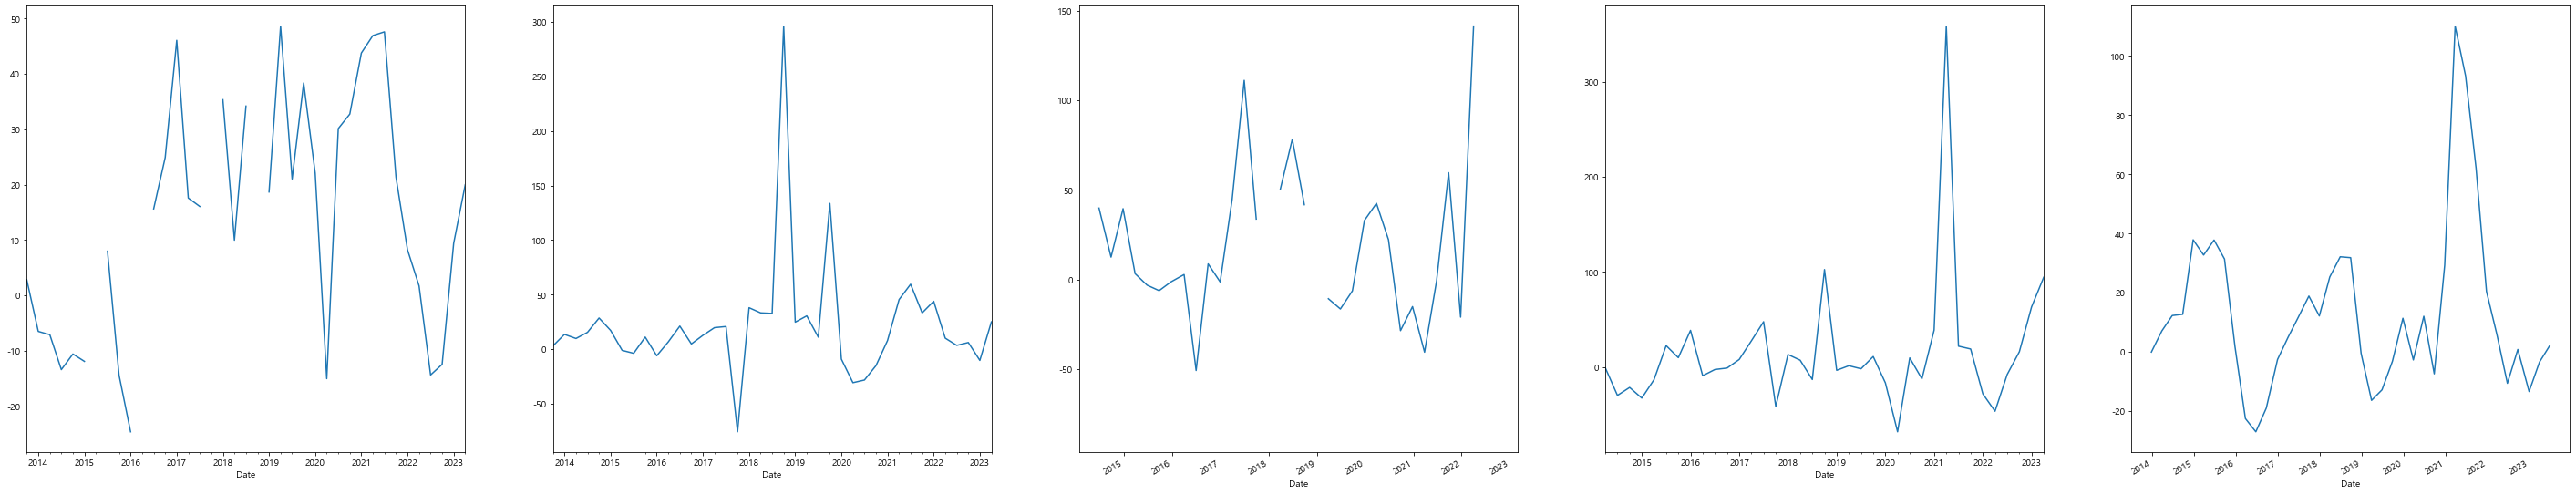

In [40]:
# 결측치가 있는 데이터에 추세가 있는지 확인해본다.
fig, ax = plt.subplots(1,5, figsize=(50,10))
msft_fs['NIG'].plot(ax=ax[0])
ma_fs['NIG'].plot(ax=ax[1])
intc_fs['NIG'].plot(ax=ax[2])
mcd_fs['NIG'].plot(ax=ax[3])
aapl_fs['NIG'].plot(ax=ax[4])
plt.show()

In [41]:
# Sklearn의 회귀 결측치 처리를 이용한다.
imp = IterativeImputer(max_iter=3, random_state=0)
msft_fs['NIG'] = imp.fit_transform(msft_fs['NIG'].values.reshape(-1,1))
intc_fs['NIG'] = imp.fit_transform(intc_fs['NIG'].values.reshape(-1,1))

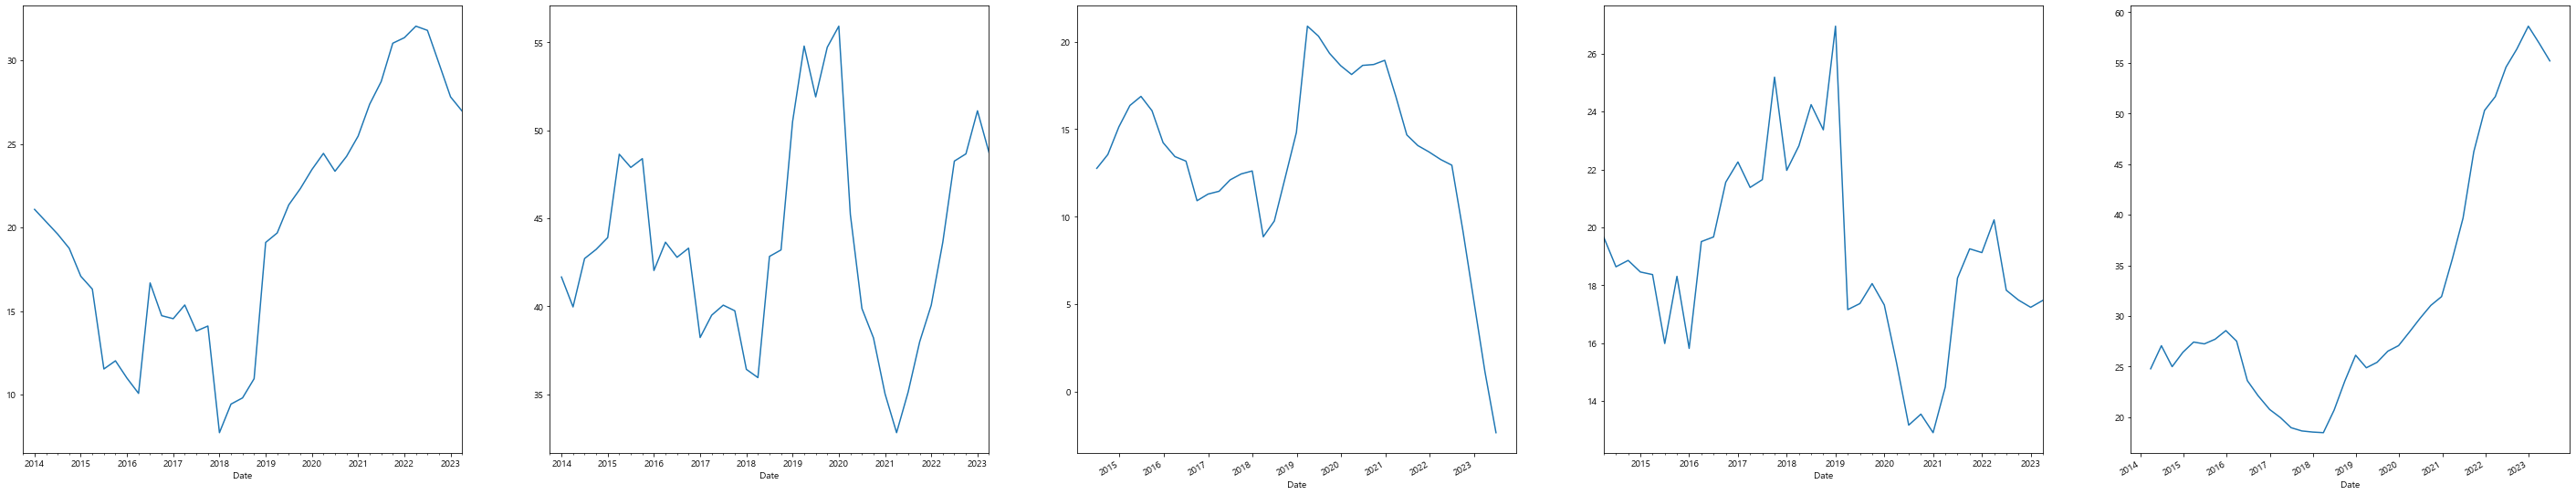

In [42]:
# ROIC의 결측치가 2013-12-31일에 발생해 분석 기간을 2014-01-01일부터 시작하도록 변경한다.
# 분석기간을 변경함으로써 DE의 결측치도 해결할 수 있다.
fig, ax = plt.subplots(1,5, figsize=(50,10))
msft_fs['ROIC'].plot(ax=ax[0])
ma_fs['ROIC'].plot(ax=ax[1])
intc_fs['ROIC'].plot(ax=ax[2])
mcd_fs['ROIC'].plot(ax=ax[3])
aapl_fs['ROIC'].plot(ax=ax[4])
plt.show()

In [43]:
# 일별 데이터로 확장한다.
msft_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2014-01-01','2023-07-01')}).set_index('Date'), msft_fs.loc["2014":]], axis=1)
msft_fs = msft_fs.fillna(method='backfill')

ma_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2014-01-01','2023-07-01')}).set_index('Date'), ma_fs.loc["2014":]], axis=1)
ma_fs = ma_fs.fillna(method='backfill')

intc_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2014-01-01','2023-07-01')}).set_index('Date'), intc_fs.loc["2014":]], axis=1)
intc_fs = intc_fs.fillna(method='backfill')

mcd_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2014-01-01','2023-07-01')}).set_index('Date'), mcd_fs.loc["2014":]], axis=1)
mcd_fs = mcd_fs.fillna(method='backfill')

aapl_fs = pd.concat([pd.DataFrame({'Date':pd.date_range('2014-01-01','2023-07-01')}).set_index('Date'), aapl_fs.loc["2014":]], axis=1)
aapl_fs = aapl_fs.fillna(method='backfill')

## Column Generation
- [API] https://pypi.org/project/TA-Lib/
- [함수설명] https://blog.naver.com/PostView.nhn?blogId=tamiel&logNo=221900701118
- [지표설명] https://alphasquare.oopy.io/board/technical-indicator/psar

#### 주가 데이터

In [44]:
def StockFeatures(DATA):
    # Returns
    
    
    # OVERLAP
    ## 지수 평활 이동평균(단기, 중기)
    DATA['MA5'] = talib.EMA(DATA['Close'], timeperiod=5)
    DATA['MA20'] = talib.EMA(DATA['Close'], timeperiod=20)
    ## 볼린저 밴드
    upper, middle, lower = talib.BBANDS(DATA['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    DATA['UPPER'] = upper
    DATA['MID'] = middle
    DATA['LOW'] = lower
    ## KAMA
    DATA['KAMA'] = talib.KAMA(DATA['Close'], timeperiod=20)
    ## PSAR(추세 전환 지표)
    DATA['PSAR'] = talib.SAR(DATA['High'], DATA['Low'], acceleration=0.02, maximum=0.2)
    
    # MOMENTUM
    ## ADX
    DATA['ADX'] = talib.ADX(DATA['High'], DATA['Low'], DATA['Close'], timeperiod=14)
    ## DX
    DATA['DX'] = talib.DX(DATA['High'], DATA['Low'], DATA['Close'], timeperiod=14)
    ## MACD
    macd, _, _ = talib.MACD(DATA['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    DATA['MACD'] = macd

    # ETC
    ## OBV
    DATA['OBV'] = talib.OBV(DATA['Close'], DATA['Volume'])
    # 변동성 지표
    DATA['ATR'] = talib.ATR(DATA['High'], DATA['Low'], DATA['Close'], timeperiod=14)
    # 투자심리선
    DATA['PSY'] = (DATA['Close'] - DATA['Close'].shift(1)).apply(lambda x: 1 if x > 0 else 0)\
                  .rolling(12).sum() / 12 * 100    
    return DATA

In [45]:
msft = StockFeatures(msft)
ma = StockFeatures(ma)
intc = StockFeatures(intc)
mcd = StockFeatures(mcd)
aapl = StockFeatures(aapl)

#### Target
다음날 증가 수익률 구간을 어떻게 나누어야 할까?
- Histogram, IQR 구간이 0을 중심으로 대부분이 -0.03, 0.03 내 대칭되어 분포함에 해당 구간은 0.01 간격으로 나누어 세부 예측한다.
- 범위 이하/이상을 한 class로 정의한다.

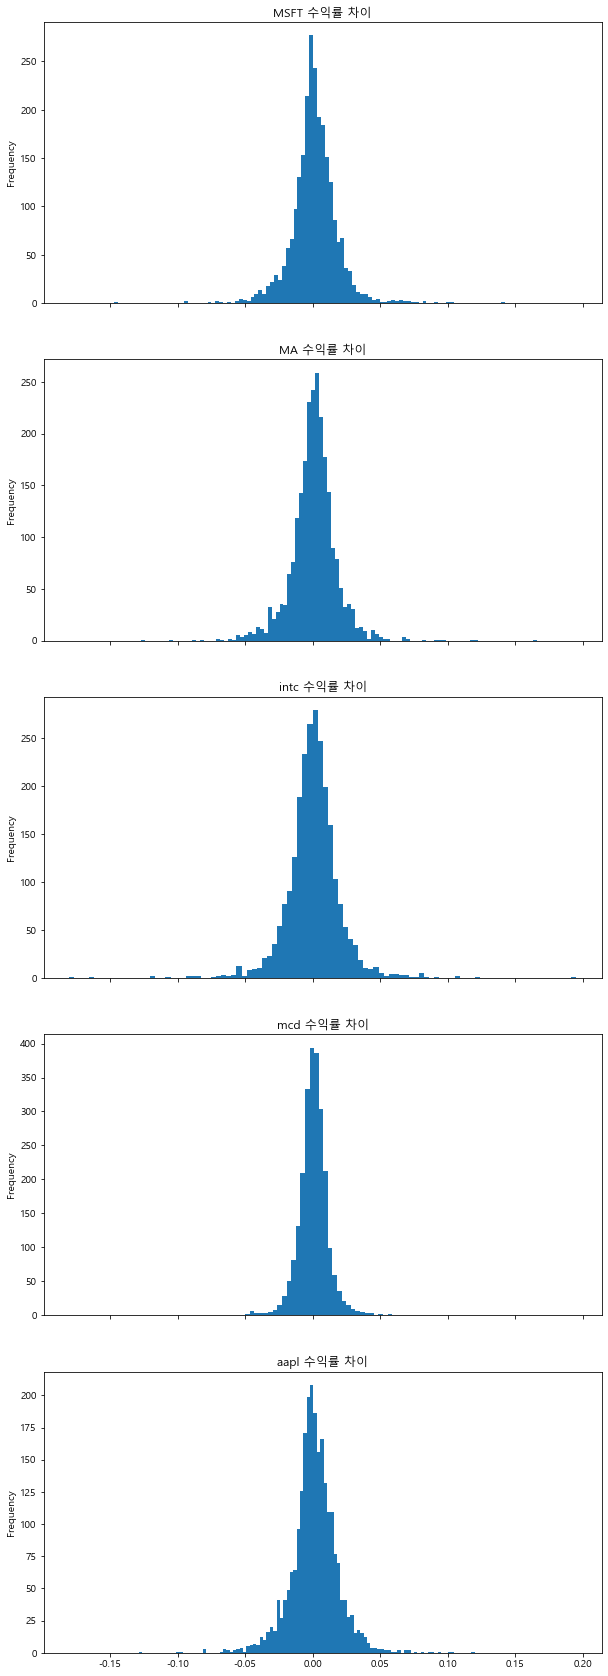

In [46]:
fig, ax = plt.subplots(5,1, sharex=True, figsize=(10,30))
((msft['Close'] - msft['Close'].shift(1))/msft['Close'].shift(1)).plot.hist(title="MSFT 수익률 차이", bins=100, ax=ax[0])
((ma['Close'] - ma['Close'].shift(1))/ma['Close'].shift(1)).plot.hist(title="MA 수익률 차이", bins=100, ax=ax[1])
((intc['Close'] - intc['Close'].shift(1))/intc['Close'].shift(1)).plot.hist(title="intc 수익률 차이", bins=100, ax=ax[2])
((mcd['Close'] - mcd['Close'].shift(1))/mcd['Close'].shift(1)).plot.hist(title="mcd 수익률 차이", bins=100, ax=ax[3])
((aapl['Close'] - aapl['Close'].shift(1))/aapl['Close'].shift(1)).plot.hist(title="aapl 수익률 차이", bins=100, ax=ax[4])
plt.show()

In [47]:
def IQR(data):
    ease = (data - data.shift(1))/data.shift(1)
    q1, q3 = ease.quantile(0.25), ease.quantile(0.75)
    lower, upper = q1 - 1.5*(q3-q1), q3 + 1.5*(q3-q1)
    return lower, upper

In [48]:
print('MSFT IQR Range:', *IQR(msft['Close']))
print('MA IQR Range:', *IQR(ma['Close']))
print('INTC IQR Range:', *IQR(intc['Close']))
print('MCD IQR Range:', *IQR(mcd['Close']))
print('AAPL IQR Range:', *IQR(aapl['Close']))

MSFT IQR Range: -0.03158177805493325 0.03454329847565472
MA IQR Range: -0.03136349378062426 0.033394713163017044
INTC IQR Range: -0.03669024687422603 0.03758028111782178
MCD IQR Range: -0.021982284620294418 0.023023619783967563
AAPL IQR Range: -0.033698357144436315 0.03674427558149736


In [49]:
def GenerateTarget(data):
    ease = (data - data.shift(1))/data.shift(1)
    ease['target'] = ease.apply(lambda x: -4 if x < -0.03 else(-3 if x < - 0.02 else(-2 if x < -0.01 else -1 if x < 0 else(
                                          1 if x < 0.01 else(2 if x < 0.02 else(3 if x < 0.03 else 4))))))
    return ease['target']

In [50]:
msft['target'] = GenerateTarget(msft['Close'])
ma['target'] = GenerateTarget(ma['Close'])
intc['target'] = GenerateTarget(intc['Close'])
mcd['target'] = GenerateTarget(mcd['Close'])
aapl['target'] = GenerateTarget(aapl['Close'])

## Merge

In [51]:
# 장이 열리는 날만 학습한다.
msft = pd.concat([msft, msft_fs, economics], axis=1).loc["2014":"2023-06-30"].dropna()
ma = pd.concat([ma, ma_fs, economics], axis=1).loc["2014":"2023-06-30"].dropna()
intc = pd.concat([intc, intc_fs, economics], axis=1).loc["2014":"2023-06-30"].dropna()
mcd = pd.concat([mcd, mcd_fs, economics], axis=1).loc["2014":"2023-06-30"].dropna()
aapl = pd.concat([aapl, aapl_fs, economics], axis=1).loc["2014":"2023-06-30"].dropna()

## Save data

In [52]:
pickle.dump((msft, ma, intc, mcd, aapl), open('data/total_data.pkl', 'wb'))

### ※ Welch_Anova Test로 유효한 변수 추출
target class별 데이터수가 다르기에 Welch_Anova Test를 수행한다.

In [53]:
welch_test = pd.DataFrame(index=[i for i in msft.columns if i != 'target'], columns=['msft','ma','intc','mcd','aapl'])

for col in welch_test.index:
    ease = [welch_anova(dv=col, between='target', data=msft).values[-1][-1],
            welch_anova(dv=col, between='target', data=ma).values[-1][-1],
            welch_anova(dv=col, between='target', data=intc).values[-1][-1],
            welch_anova(dv=col, between='target', data=mcd).values[-1][-1],
            welch_anova(dv=col, between='target', data=aapl).values[-1][-1]]
    welch_test.loc[col] = ease

In [54]:
welch_test.applymap(lambda x: 1 if x < 0.05 else 0)

,msft,ma,intc,mcd,aapl
Open,1,1,1,1,1
High,1,1,1,1,1
Low,1,1,1,1,1
Close,1,1,1,1,1
Adj Close,1,1,1,1,1
Volume,0,0,0,0,0
MA5,1,1,1,1,1
MA20,1,1,1,1,1
UPPER,1,1,1,1,1
MID,1,1,1,1,1
